# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [148]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        dot_w_x = X @ weights
        return (1 / (1 + np.exp(-dot_w_x)))
    
    def get_loss(self, x, weights, y):
        reg = np.sum(weights ** 2) / (2 * self.C)
        loss = np.sum([np.log(1 + np.exp(-(weights @ x[j, :]) * y[j])) for j in range(len(y))], axis=0) / len(y) + reg
        return loss
    
    
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization 
        self.losses = []
        self.losses.append(self.get_loss(X_ext, self.weights_, y))
        for i in range(self.max_iter):
            l_slog = []
            for ii in range(y.shape[0]):
                list_slog = y[ii] * X_ext[ii, :] * (1 - 1 / (1 + np.exp(-X_ext[ii, :] @ self.weights_ * y[ii])))
                l_slog.append(list_slog)
            delta = -np.sum(np.array(l_slog), axis = 0)/ X_ext.shape[0] + self.weights_/self.C
            self.weights_ -= self.eta * delta
            self.losses.append(self.get_loss(X_ext, self.weights_, y))
            
            if np.sqrt(np.sum(delta ** 2)) < self.tol:
                print('break')
                break
        
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        if hasattr(self, 'weights_'):
            cl = self.predict_proba(X)
            return np.where(cl < 0.5, -1, 1)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

In [149]:
from sklearn import datasets
from sklearn import metrics

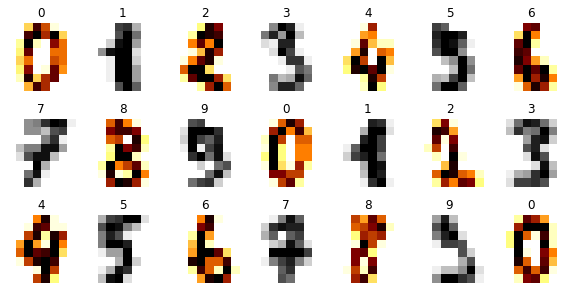

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

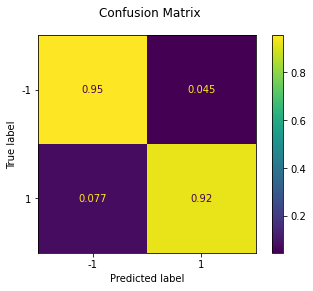

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

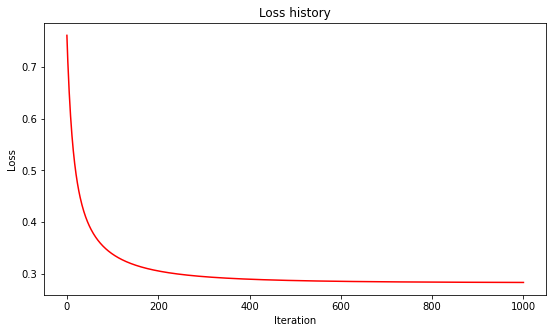

In [16]:
plt.figure(figsize=(9, 5))
plt.plot(model.losses, 'r')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

We can see that with iteration increasing loss function is getting smaller (and becomes close to 0). As we expected by moving opposite direction of the gradient.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [18]:
accuracy_train = []
accuracy_test = []
y_loss = []

etas = np.linspace(0.000, 0.050, 100)
for eta in etas:
    model = CustomLogisticRegression(eta=eta)
    model.fit(X_train, y_train)
    y_loss.append(model.losses[-1])
    accuracy_train.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    accuracy_test.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

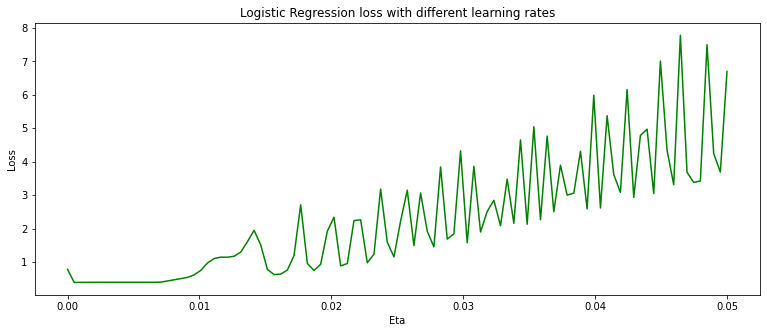

In [19]:
plt.figure(figsize=(13, 5))
plt.plot(etas, y_loss, 'green')
plt.xlabel('Eta')
plt.ylabel('Loss')
plt.title('Logistic Regression loss with different learning rates')
plt.show()

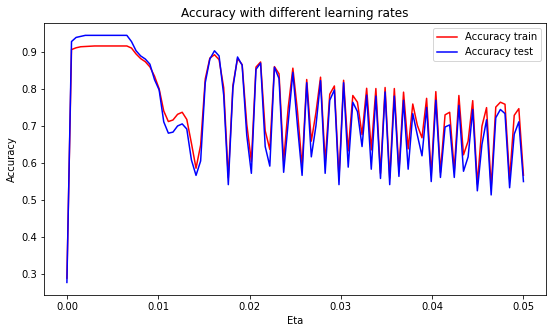

In [20]:
plt.figure(figsize=(9, 5))
plt.plot(etas, accuracy_train, 'r')
plt.plot(etas, accuracy_test, 'b')
plt.legend(['Accuracy train', 'Accuracy test'])
plt.xlabel('Eta')
plt.ylabel('Accuracy')
plt.title('Accuracy with different learning rates')
plt.show()

There is a range of values of learning rate where the model is optimal (very small loss and high accuracies - learning rate is about 0.001 and above 0.01).

Learning rate makes training process (gradient step) very slowly with values close to 0. Because it produces very small values of gradient step - so function can never get to the best option.

From the plot we can see that with values of learning rate close to 0 - model didn't approach the best result.

And after the range of optimal values of learning rate, model lost its quality. With bigger values of learning rate gradient step is also doiing bigger steps - so there is harder for model to rich the smallest lost and as a result we get worse values of accuracy.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [21]:
c_s = np.linspace(0.1, 100, 100)
accuracy_train = []
accuracy_test = []
y_loss = []

for c in c_s:
    model = CustomLogisticRegression(C=c)
    model.fit(X_train, y_train)
    y_loss.append(model.losses[-1])
    accuracy_train.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    accuracy_test.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

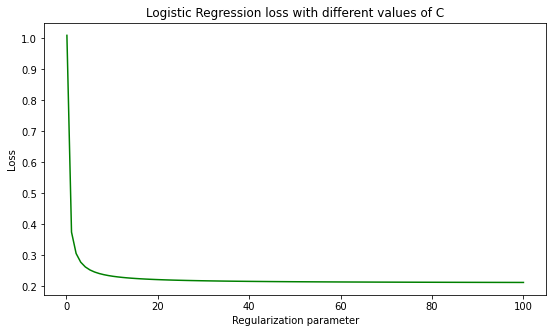

In [22]:
plt.figure(figsize=(9, 5))
plt.plot(c_s, y_loss, 'green')
plt.xlabel('Regularization parameter')
plt.ylabel('Loss')
plt.title('Logistic Regression loss with different values of C')
plt.show()

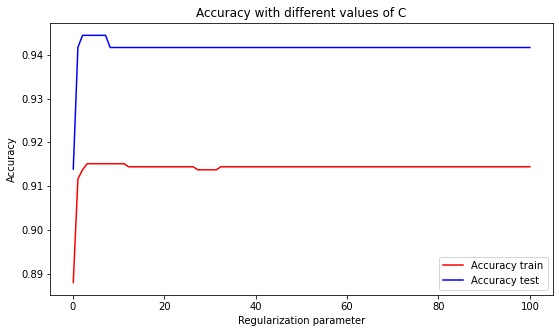

In [23]:
plt.figure(figsize=(9, 5))
plt.plot(c_s, accuracy_train, 'r')
plt.plot(c_s, accuracy_test, 'b')
plt.legend(['Accuracy train', 'Accuracy test'])
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy with different values of C')
plt.show()

Regularization parameter value also has influence on gradint step while training, but the relationship is inversed and has smaller effect. So, with bigger values of regularization parameter we see on the plot better loss and accuracy.

So, influnce of regularization parameter value exist, and it is much more inert than of the learning rate.

**(0.5 points)** Compare zero initialization and random initialization. 

In [24]:
iter_count = np.linspace(1, 1000, 100, dtype=np.int64)

In [25]:
model_random = CustomLogisticRegression(zero_init=False)
model_zero = CustomLogisticRegression(zero_init=True)
model_random.fit(X_train, y_train)
model_zero.fit(X_train, y_train)

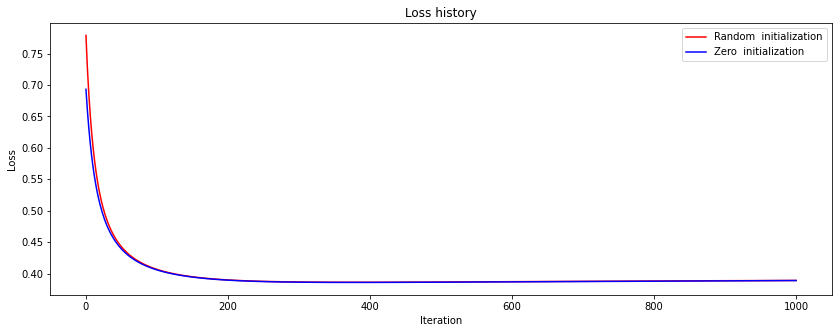

In [26]:
plt.figure(figsize=(14, 5))
plt.plot(model_random.losses, 'r')
plt.plot(model_zero.losses, 'b')
plt.legend(['Random  initialization', 'Zero  initialization'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

In [27]:
ac_train_random = metrics.accuracy_score(y_pred=model_random.predict(X_train), y_true=y_train)
ac_test_random = metrics.accuracy_score(y_pred=model_random.predict(X_test), y_true=y_test)
ac_train_zero = metrics.accuracy_score(y_pred=model_zero.predict(X_train), y_true=y_train)
ac_test_zero = metrics.accuracy_score(y_pred=model_zero.predict(X_test), y_true=y_test)
print(f'Train/test accuracy with random initialization: {np.round(ac_train_random, 5)} / {np.round(ac_test_random, 5)}')
print(f'Train/test accuracy with zero initialization:   {np.round(ac_train_zero, 5)} / {np.round(ac_test_zero, 5)}')

Train/test accuracy with random initialization: 0.91093 / 0.93889
Train/test accuracy with zero initialization:   0.91162 / 0.93889


There are almost the same plots for both random and zero weights initialization. It's only a little difference in the beginning of training process, where loss with random initialization is a little bigger.

But resulting test accuracy is the same, so it doesn't make enough influence for the loss function. Only with small values of iteration there is a small enlarging of quality for the loss with zero initialization.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [28]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        array_distance_inv = []
        for j in range(Y.shape[0]):
            array_distance_inv.append(np.sqrt(np.sum((X - Y[j]) ** 2, axis=1)))
        return np.array(array_distance_inv).T
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        if hasattr(self, 'classes_'):
            p = []
            for i in range(len(self.classes_)):
                p.append(np.sum(weights[y == self.classes_[i]]))
            return np.array(p)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)   
                
            p_sort = np.argsort(P, axis = 1)[:, :self.n_neighbors]
           
            weights_y = []
            for i in range(len(p_sort)):              
                weights_y.append(self.get_class_weights(self.y[p_sort[i]], weights_of_points[i, p_sort[i]]))                               
            weights_y = np.array(weights_y)
            weights_y_sum = np.sum(weights_y, axis = 1)
            
            ret_arr = []
            for i in range(len(p_sort)):
                l = weights_y[i] / weights_y_sum[i]
                ret_arr.append(l)
                            
            return np.array(ret_arr)
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
    
        return np.argmax(self.predict_proba(X), axis = 1)
        pass

In [29]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [30]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [31]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

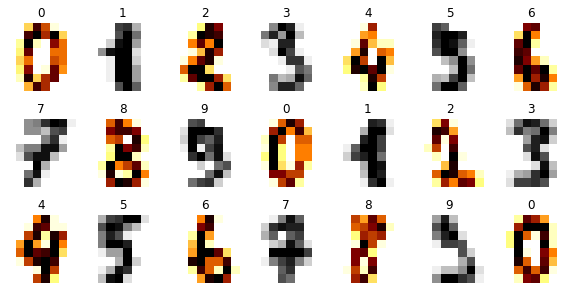

In [32]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [33]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [34]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

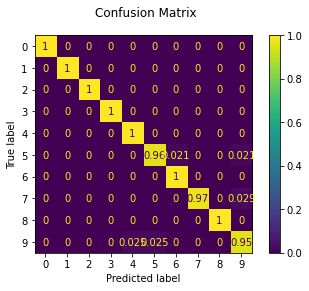

In [35]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [36]:
assert train_acc == 1
assert test_acc > 0.98

In [37]:
train_acc, test_acc

(1.0, 0.9861111111111112)

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

The model confuses numbers 4, 5, 6, 7 and 9.

It happens because of the some characteristic pattern of writen numbers (similar loops, roundings). 

For example numbers 5 and 6 differ only by a character of left line. But differet people can write this line by their only way - so sometimes it's defficult for model to detect right.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [38]:
train_acc, test_acc = [], []

for n_n in range(1, 16):
    model = CustomKNeighborsClassifier(n_neighbors=n_n)
    model.fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    

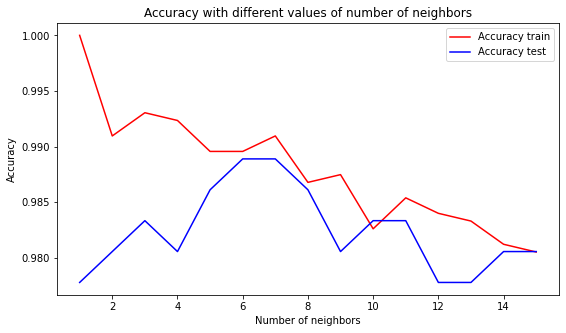

In [39]:
plt.figure(figsize=(9, 5))
plt.plot(range(1, 16), train_acc, 'r')
plt.plot(range(1, 16), test_acc, 'b')
plt.legend(['Accuracy train', 'Accuracy test'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy with different values of number of neighbors')
plt.show()

There is a decreasing of train accuracy with bigger numbers of neighbors, and an increasing at the beginning and then decreasing of test accuracy. At the value of neighbors about 6 it's the smallest differnce between train and test accuracies and below that value they are dispersing.

I think it depends on the specific of classes distribution. Whether there are outliers and the dispersion of each class.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

Distance method


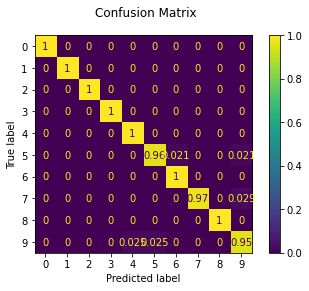

Uniform method


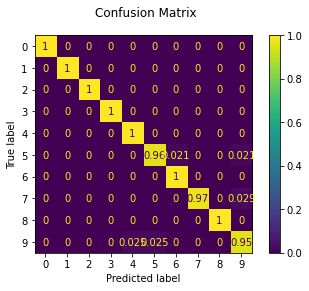

Train/test accuracy for distance method: 1.0 / 0.986111
Train/test accuracy for uniform method:  0.989562 / 0.986111


In [40]:
model_dist = CustomKNeighborsClassifier(weights='distance')
model_uni = CustomKNeighborsClassifier(weights='uniform')

model_dist.fit(X_train, y_train)
model_uni.fit(X_train, y_train)

print('Distance method')
train_acc_dist, test_acc_dist = fit_evaluate(model_dist, X_train, y_train, X_test, y_test)
print('Uniform method')
train_acc_uni, test_acc_uni = fit_evaluate(model_uni, X_train, y_train, X_test, y_test)

print(f'Train/test accuracy for distance method: {np.round(train_acc_dist, 6)} / {np.round(test_acc_dist, 6)}')
print(f'Train/test accuracy for uniform method:  {np.round(train_acc_uni, 6)} / {np.round(test_acc_uni, 6)}')

Train accuracy is a little better in case with distance method but test accuracy is the same.

I think that distance method may be will be better with a large number of classes with big dispersion. Where there is an importance not only for class of the nearest neighbors but also the distance between them.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

As a thought may be it will be better to invent a bigger penalty for the furtherest point among nearest neighbors and enlarge them twice.

In [41]:
class MaxPenaltyCustomKNeighborsClassifier(CustomKNeighborsClassifier):
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
            if self.weights == 'max_penalty':
                weights_of_points = (1 / (P ** 2 + self.eps))
                
            p_sort = np.argsort(P, axis = 1)[:, :self.n_neighbors]
           
            weights_y = []
            for i in range(len(p_sort)):              
                weights_y.append(self.get_class_weights(self.y[p_sort[i]], weights_of_points[i, p_sort[i]]))                               
            weights_y = np.array(weights_y)
            weights_y_sum = np.sum(weights_y, axis = 1)
            
            ret_arr = []
            for i in range(len(p_sort)):
                l = weights_y[i] / weights_y_sum[i]
                ret_arr.append(l)
                            
            return np.array(ret_arr)
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")


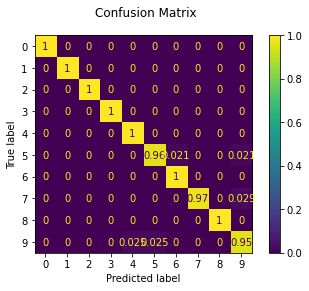

In [42]:
model = MaxPenaltyCustomKNeighborsClassifier(n_neighbors=5, weights='max_penalty')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [43]:
train_acc, test_acc

(1.0, 0.9861111111111112)

So, we have the same result as for previous method.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

It could be better in this case to use Manhattan distance to calculate the distance between points. Manhattan distance calculates the distance in a in a grid like path |_ . And firsly we have a pictures wich consist of the pixels.

Let's find that out.

In [46]:
class ManhattanCustomKNeighborsClassifier(CustomKNeighborsClassifier):
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        array_distance_inv = []
        for j in range(Y.shape[0]):
            array_distance_inv.append(np.sum(np.abs(X - Y[j]), axis=1))
        return np.array(array_distance_inv).T

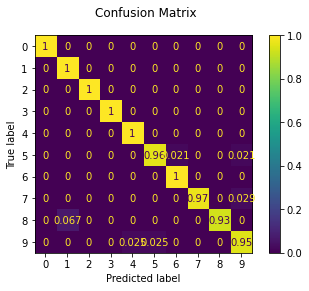

In [47]:
model = ManhattanCustomKNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [48]:
train_acc, test_acc

(0.9902574808629089, 0.9805555555555555)

Let's try Chebyshev distance method.

In [49]:
class MaxCustomKNeighborsClassifier(CustomKNeighborsClassifier):
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        array_distance_inv = []
        for j in range(Y.shape[0]):
            array_distance_inv.append(np.max(np.abs(X - Y[j]), axis=1))
        return np.array(array_distance_inv).T

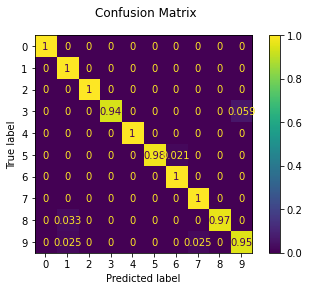

In [50]:
model = MaxCustomKNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [51]:
train_acc, test_acc

(0.9867780097425192, 0.9833333333333333)

All models are a little bit worse than our class with Euclidean distance method.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [106]:
PATH = "./data/"

In [304]:
#data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data = pd.read_csv('train.csv').set_index('PassengerId')

In [133]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [109]:
data['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

Text(0, 0.5, 'Density')

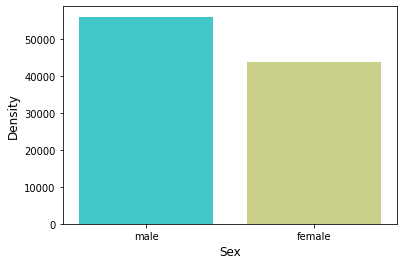

In [110]:
sns.countplot(data=data, x='Sex', palette='rainbow')
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Density', fontsize=12)

In [10]:
data['Survived'].value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

Text(0, 0.5, 'Density')

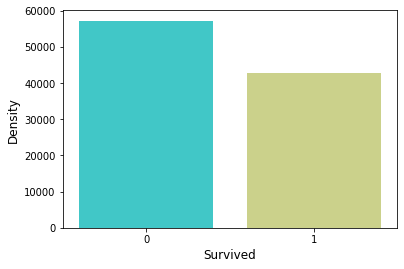

In [11]:
sns.countplot(data=data, x='Survived', palette='rainbow')
plt.xlabel('Survived', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0, 0.5, 'Quantity')

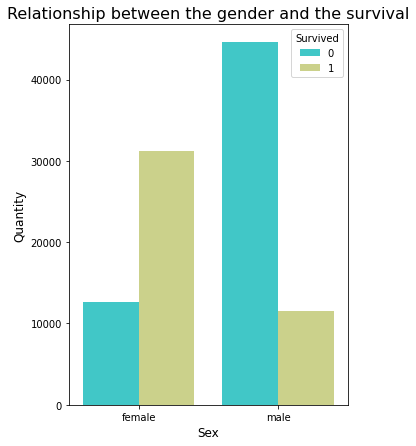

In [14]:
gr_by_surv = data.groupby(['Survived','Sex'])['Name'].count().reset_index().rename(columns={'Name' : 'Quantity'})

plt.figure(figsize=(5,7))
sns.barplot(x=gr_by_surv['Sex'], y=gr_by_surv['Quantity'], hue=gr_by_surv['Survived'], palette='rainbow')
plt.title('Relationship between the gender and the survival', fontsize = 16)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

In the dataset there were more males then females.

Unfortunatly less people survived.

We can surely say that there is relationship between the gender and the survival - among females there are much more survivied then among males, though on the whole there were less females.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Text(0, 0.5, 'Density')

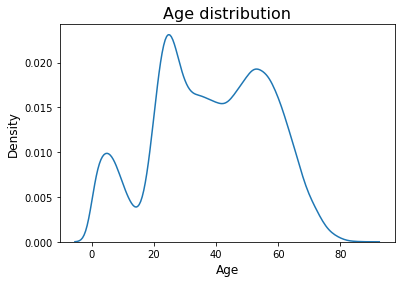

In [15]:
sns.kdeplot(data=data, x='Age')
plt.title('Age distribution', fontsize = 16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)

In [25]:
print(f"The average age of survived passengers {data[data['Survived'] == 1]['Age'].mean()}")
print(f"The median age of survived passengers {data[data['Survived'] == 1]['Age'].median()}")

The average age of survived passengers 40.55379931430776
The median age of survived passengers 43.0


In [26]:
print(f"The average age of deceased passengers {data[data['Survived'] == 0]['Age'].mean()}")
print(f"The median age of deceased passengers {data[data['Survived'] == 0]['Age'].median()}")

The average age of deceased passengers 36.708694881533724
The median age of deceased passengers 36.0


We can notice that on the average survived passengers were older.

As we can see there is a difference in distributions - when average and median are almost the same for deceased passengers, for survived passengers an average age is a little smaller then median, that means that distribution is skewed.
Let's see on plot:

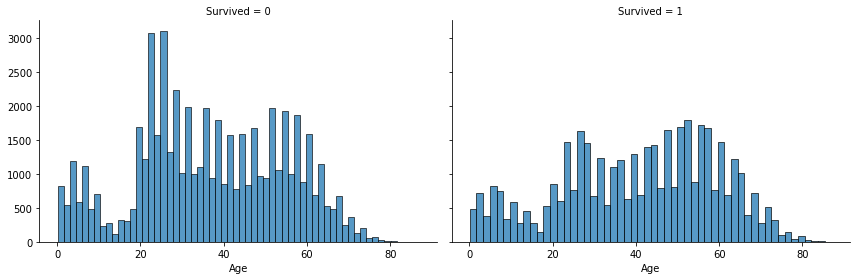

In [75]:
g = sns.FacetGrid(data, col="Survived", height=4, aspect=1.5)
g.map(sns.histplot, "Age");

Distribution of age for survived passengers is a little negative skewed. It may be related to the situation when the resque priority was given to older people.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Text(0, 0.5, 'Quantity')

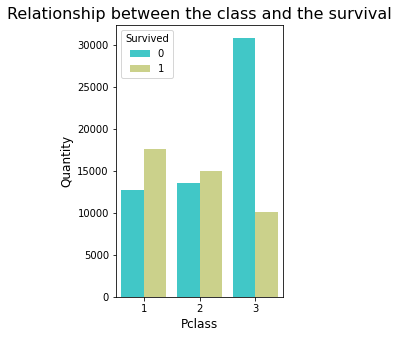

In [54]:
gr_by_class = data.groupby(['Survived','Pclass'])['Name'].count() \
                                    .reset_index().rename(columns={'Name' : 'Quantity'})

plt.figure(figsize=(3,5))
sns.barplot(x=gr_by_class['Pclass'], y=gr_by_class['Quantity'], hue=gr_by_class['Survived'], palette='rainbow')
plt.title('Relationship between the class and the survival', fontsize = 16)
plt.xlabel('Pclass', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

We can call the first class "the safest" - there are more survived there, when the theird class has the opposite image.

Text(0, 0.5, 'Quantity')

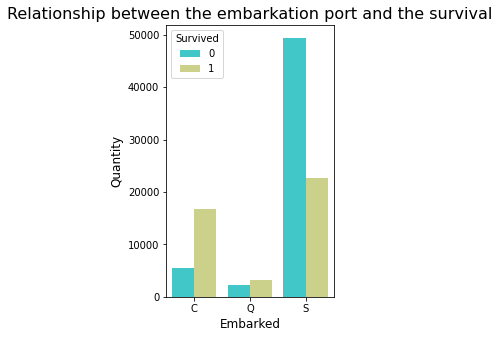

In [57]:
gr_by_emb = data.groupby(['Survived','Embarked'])['Name'].count() \
                                    .reset_index().rename(columns={'Name' : 'Quantity'})

plt.figure(figsize=(3,5))
sns.barplot(x=gr_by_emb['Embarked'], y=gr_by_emb['Quantity'], hue=gr_by_emb['Survived'], palette='rainbow')
plt.title('Relationship between the embarkation port and the survival', fontsize = 16)
plt.xlabel('Embarked', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

Seems like there is a relationship between the embarkation port and the survival. Passengers embarked in C port were more lucky to be survived.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 11.2+ MB


In [134]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'Percent_missing, %': percent_missing})
missing_value_df

,"Percent_missing, %"
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
Age,3.292
SibSp,0.000
Parch,0.000
Ticket,4.623
Fare,0.134
Cabin,67.866


There are a lot of missing values in column "Cabin": 67,866%.

Also columns "Age", "Ticket", "Fare" and "Embarked" have missing values.

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We can replace these missing values with average or mode. Advantages: we have less Nan values means that we have more datas at all, and it will be good for the training and testing the model. Disadvantages: it can provide wrong value in some cases what will provide worse model metrics and predicting possibility.

We can get samples which have smaller distance from sample with missing value and use their value instead of missing value. Advantages: it seems to be better option then the first suggestion but, Disadvantages: it is getting worse whith more missing values in one sample.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Let's replace missing values in 'Age' by mode of these columns, but having similar values.


In [305]:
mode_age_surv_male = data[(data['Survived'] == 1) & (data['Sex'] == 'male')]['Age'].mode().values[0]
mode_age_surv_female = data[(data['Survived'] == 1) & (data['Sex'] != 'male')]['Age'].mode().values[0]
mode_age_not_surv_male = data[(data['Survived'] == 0) & (data['Sex'] == 'male')]['Age'].mode().values[0]
mode_age_not_surv_female = data[(data['Survived'] == 0) & (data['Sex'] != 'male')]['Age'].mode().values[0]

data.loc[(data['Age'].isna()) & (data['Survived'] == 1) & (data['Sex'] == 'male'), 'Age'] = mode_age_surv_male
data.loc[(data['Age'].isna()) & (data['Survived'] == 1) & (data['Sex'] != 'male'), 'Age'] = mode_age_surv_female
data.loc[(data['Age'].isna()) & (data['Survived'] == 0) & (data['Sex'] == 'male'), 'Age'] = mode_age_not_surv_male
data.loc[(data['Age'].isna()) & (data['Survived'] == 0) & (data['Sex'] != 'male'), 'Age'] = mode_age_not_surv_female

In [306]:
data['Age'].isna().sum()

0

In [327]:
data.loc[data['Fare'].isna(), 'Fare'] = data['Fare'].mode().values[0]

In [328]:
data['Fare'].isna().sum()

0

In [329]:
data_new = data

In [330]:
data_new['Family size'] = data['SibSp'] + data['Parch']
d = {0: 1}
data_new['Is alone'] = data_new['Family size'].map(d)
data_new['Is alone']=data_new['Is alone'].fillna(0)
data_new

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family size,Is alone
PassengerId,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,23.00,2,0,209245,27.14,C12239,S,2,0.0
1,0,3,"Bryan, Drew",male,23.00,0,0,27323,13.35,NaN,S,0,1.0
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,3,0.0
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,0,1.0
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C,0,1.0
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S,0,1.0
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S,0,1.0


We will choose as features columns 'Age', 'Pclass', 'Sex', 'Embarked' and target = 'Survived'.

Let's convert categorical columns 'Pclass', 'Sex, 'Embarked' into indicator variables. Also missing values in 'Embarcked' will be replaced by no one of the ports.

In [331]:
features = ['Age', 'Pclass', 'Sex', 'Embarked', 'Fare', 'Family size', 'Is alone']
target = ['Survived']
X = data_new[features]
y = data_new[target].values

X = pd.get_dummies(X, columns=['Pclass', 'Sex', 'Embarked'], dtype=int)
X

,Age,Fare,Family size,Is alone,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
0,23.00,27.14,2,0.0,1,0,0,0,1,0,0,1
1,23.00,13.35,0,1.0,0,0,1,0,1,0,0,1
2,0.33,71.29,3,0.0,0,0,1,0,1,0,0,1
3,19.00,13.04,0,1.0,0,0,1,0,1,0,0,1
4,25.00,7.76,0,1.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,62.00,14.86,0,1.0,0,1,0,1,0,1,0,0
99996,66.00,11.15,0,1.0,0,1,0,0,1,0,0,1
99997,37.00,9.95,0,1.0,0,0,1,0,1,0,0,1


In [332]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Age          100000 non-null  float64
 1   Fare         100000 non-null  float64
 2   Family size  100000 non-null  int64  
 3   Is alone     100000 non-null  float64
 4   Pclass_1     100000 non-null  int32  
 5   Pclass_2     100000 non-null  int32  
 6   Pclass_3     100000 non-null  int32  
 7   Sex_female   100000 non-null  int32  
 8   Sex_male     100000 non-null  int32  
 9   Embarked_C   100000 non-null  int32  
 10  Embarked_Q   100000 non-null  int32  
 11  Embarked_S   100000 non-null  int32  
dtypes: float64(3), int32(8), int64(1)
memory usage: 6.9 MB


We will use StandardScaler to normalize features.

In [333]:
ss = StandardScaler()
ss.fit(X)
X = ss.transform(X)

In [334]:
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [335]:
model_log = LogisticRegression()
cross_validate(model_log, X, y.ravel(), cv=5, scoring={'accuracy_score': make_scorer(metrics.accuracy_score)})

{'fit_time': array([0.08780909, 0.08477473, 0.07983613, 0.07713127, 0.08306193]),
 'score_time': array([0.00201988, 0.00221157, 0.00099945, 0.00197005, 0.00228977]),
 'test_accuracy_score': array([0.76575, 0.76195, 0.7644 , 0.7645 , 0.7639 ])}

In [336]:
model_knn = KNeighborsClassifier()
cross_validate(model_knn, X, y.ravel(), cv=5, scoring={'accuracy_score': make_scorer(metrics.accuracy_score)})

{'fit_time': array([2.82743883, 2.70174527, 2.69778752, 2.80652165, 2.69080687]),
 'score_time': array([1.93086791, 2.11836576, 1.99264336, 2.09238124, 1.85107493]),
 'test_accuracy_score': array([0.74275, 0.743  , 0.7421 , 0.74275, 0.74275])}

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [205]:
search = GridSearchCV(LogisticRegression(), {'C': np.arange(1, 10), \
                                            'penalty' : ['l2'],}, cv=5)

In [206]:
search.fit(X, y.ravel())

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'penalty': ['l2']})

In [207]:
search.best_params_

{'C': 1, 'penalty': 'l2'}

In [208]:
search.best_score_

0.76306

In [197]:
search = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(1, 15)}, cv=5)

In [198]:
search.fit(X, y.ravel())

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [199]:
search.best_params_

{'n_neighbors': 14}

In [200]:
search.best_score_

0.75697

In [251]:
pol = PolynomialFeatures(degree= 2)
X_poly = pol.fit_transform(X)

In [254]:
model_log = LogisticRegression(max_iter = 50000)
cross_validate(model_log, X_poly, y.ravel(), cv=5, scoring={'accuracy_score': make_scorer(metrics.accuracy_score)})

{'fit_time': array([1.69692087, 1.62466002, 1.41756511, 1.31448793, 1.50597572]),
 'score_time': array([0.00299001, 0.0029881 , 0.00199342, 0.00299001, 0.00299025]),
 'test_accuracy_score': array([0.7643 , 0.7659 , 0.7674 , 0.76685, 0.7664 ])}

In [278]:
X = np.c_[X, X[:,[1,4,6]].sum(axis=1)]
X.shape

(100000, 10)

In [279]:
model_log = LogisticRegression()
cross_validate(model_log, X, y.ravel(), cv=5, scoring={'accuracy_score': make_scorer(metrics.accuracy_score)})

{'fit_time': array([0.09036136, 0.0885365 , 0.0827775 , 0.0787642 , 0.07678843]),
 'score_time': array([0.00197792, 0.00251889, 0.00199461, 0.00196028, 0.00196981]),
 'test_accuracy_score': array([0.76475, 0.76145, 0.76425, 0.7635 , 0.76135])}

In [280]:
pol = PolynomialFeatures(degree = 2)
X_poly = pol.fit_transform(X)

In [281]:
model_log = LogisticRegression(max_iter = 50000)
cross_validate(model_log, X_poly, y.ravel(), cv=5, scoring={'accuracy_score': make_scorer(metrics.accuracy_score)})

{'fit_time': array([0.75191784, 0.7202661 , 0.68811917, 0.60338807, 0.84521055]),
 'score_time': array([0.00299048, 0.00298977, 0.00299048, 0.0029912 , 0.00299072]),
 'test_accuracy_score': array([0.7643 , 0.76585, 0.7674 , 0.76685, 0.7664 ])}

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.